In [1]:
from src.mobile_net import MobileNetV2Encoder,mobilenet_encoders
from src.resnet_backbone import ResNetEncoder,resnet_encoders
from src.dense_net_backbone import DenseNetEncoder, densenet_encoders
from src.vgg_backbone import VGGEncoder, vgg_encoders

from src.unet_plus import UnetPlusPlus
import torch
import numpy as np
import pandas as pd
import json,os,sys

In [2]:
# load encoder

model = UnetPlusPlus(encoder_name = "mobilenet_v2",
                     encoder_depth=5,
                     encoder_weights='imagenet',
                     dict_encoder=mobilenet_encoders,
                     in_channels=3,
                    activation='sigmoid')
#                     
# model2 = UnetPlusPlus(
#                     encoder_name = "resnet34",
#                      encoder_depth=5,
#                      encoder_weights='imagenet',
#                      dict_encoder=resnet_encoders,
#                      in_channels=3
# )
# model3 = UnetPlusPlus(
#              encoder_name = "resnet18",
#                      encoder_depth=5,
#                      encoder_weights='imagenet',
#                      dict_encoder=resnet_encoders,
#                      in_channels=3
# )
# model4 =  UnetPlusPlus(
#              encoder_name = "resnext50_32x4d",
#                      encoder_depth=5,
#                      encoder_weights='imagenet',
#                      dict_encoder=resnet_encoders,
#                      in_channels=3
# )
# model5 = UnetPlusPlus(
#              encoder_name = "densenet121",
#                      encoder_depth=5,
#                      encoder_weights='imagenet',
#                      dict_encoder=densenet_encoders,
#                      in_channels=3
# )

# model6 = UnetPlusPlus(
#              encoder_name = "vgg13_bn",
#                      encoder_depth=5,
#                      encoder_weights='imagenet',
#                      dict_encoder=vgg_encoders,
#                      in_channels=3
# )


In [3]:
print(f"backbone_mobile_netv2 : {np.sum([i.numel() for i in model.parameters()]):,}")
# print(f"backbone_resnet34 : {np.sum([i.numel() for i in model2.parameters()]):,}")
# print(f"backbone_resnet18 : {np.sum([i.numel() for i in model3.parameters()]):,}")
# print(f"backbone_resnext50_32x4d : {np.sum([i.numel() for i in model4.parameters()]):,}")
# print(f"backbone_densenet121 : {np.sum([i.numel() for i in model5.parameters()]):,}")
# print(f"backbone_vgg13_bn : {np.sum([i.numel() for i in model6.parameters()]):,}")

backbone_mobile_netv2 : 6,824,721


In [4]:
model

UnetPlusPlus(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), b

In [4]:
image = torch.zeros(1,3,320,320)
out = model(image)

In [5]:
out.size()

torch.Size([1, 1, 320, 320])

In [21]:
from utils.train import TrainEpoch,ValidEpoch
from utils.metric import IoU, Accuracy
from utils.loss import DiceLoss

In [7]:
mask = torch.ones(1,3,320,320)

In [8]:
loss = DiceLoss()
me = [IoU(),Accuracy()]
# loss(out,mask),me.forward(out,mask)

In [9]:
import glob,cv2


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def preprocess_input(
    x, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], input_space="RGB", input_range=[0,1], **kwargs
):

    if input_space == "BGR":
        x = x[..., ::-1].copy()

    if input_range is not None:
        if x.max() > 1 and input_range[1] == 1:
            x = x / 255.0

    if mean is not None:
        mean = np.array(mean)
        x = x - mean

    if std is not None:
        std = np.array(std)
        x = x / std

    return x


class DataTrafic(torch.utils.data.Dataset):
    img_end_with = ["png","jpg","pnm","jpeg"]
    def __init__(self, folder_dir:str=None, augmentation = None, preprocessing=None,classes = None):
        assert folder_dir is not None, "folder_dir should be provide"
        
        self.folder_dir = folder_dir
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.classes = classes
        
        if self.classes is None:
            print("None classes set to default 0")
            self.classes = [0]
        
        self.image_dir = os.path.join(self.folder_dir,"images")
        self.mask_dir = os.path.join(self.folder_dir,"masks")
        
        self.list_img = []
        for type_end in DataTrafic.img_end_with:
            self.list_img = self.list_img + list(glob.glob(os.path.join(self.image_dir,f"*.{type_end}")))
         
    
    def __len__(self):return len(self.list_img)
    
    def get_file_mask(self,index):
        name = self.list_img[index].split(os.path.sep)[-1].split(".")[0]
        end_type = self.list_img[index].split(os.path.sep)[-1].split(".")[1]
        name = name + "_color_mask.png"
#         print(name)
        return os.path.join(self.mask_dir,name)
    
    def __getitem__(self,index):
        
        origin_img = cv2.imread(self.list_img[index])
        image = cv2.cvtColor(origin_img,cv2.COLOR_BGR2RGB) # RED-GREEN-BLUE
        
        
        mask = cv2.imread(self.get_file_mask(index),cv2.COLOR_BGR2GRAY)[...,0]
#         print(mask.shape,mask[...,0].min(),mask[...,1].min(),mask[...,2].min())
        masks = [(mask == v) for v in self.classes]
        mask = np.stack(masks, axis=-1).astype('float')
#         print(origin_img.shape,mask.shape)
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
        
        
        
        
        
        
    

In [50]:
import albumentations as A
import albumentations.augmentations.functional as FA
from albumentations.pytorch import ToTensorV2
from tqdm.notebook import tqdm


train_transform = A.Compose(
    [
        A.PadIfNeeded(min_height=256, min_width=256),
        A.RandomCrop(256, 256),
        A.RandomBrightnessContrast(p=0.4),
        
    ]
)

val_transform = A.Compose(
    [
        A.PadIfNeeded(min_height=256, min_width=256),
        A.CenterCrop(256, 256),
    ]
)
# A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
#         ToTensorV2(),


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
        A.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return A.Compose(_transform)

In [51]:
folder  = "./data/"
train_data = DataTrafic(folder,augmentation=train_transform,preprocessing = get_preprocessing(preprocess_input))
vali_data = DataTrafic("./validation/",augmentation=val_transform,preprocessing=get_preprocessing(preprocess_input))

None classes set to default 0
None classes set to default 0


In [52]:
import matplotlib.pyplot as plt
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image.transpose(1,2,0))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 256, 256) (1, 256, 256) ./data/images/81.jpg ./data/masks/81_color_mask.png


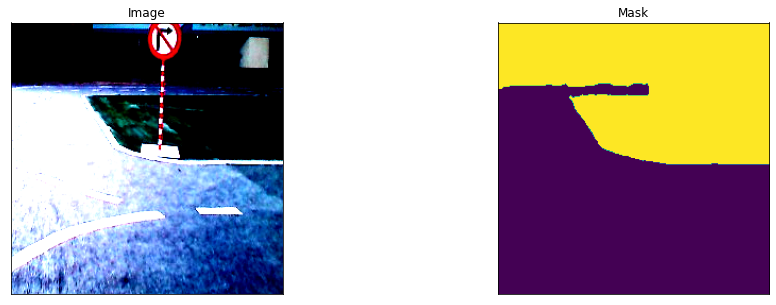

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 256, 256) (1, 256, 256) ./data/images/3742.jpg ./data/masks/3742_color_mask.png


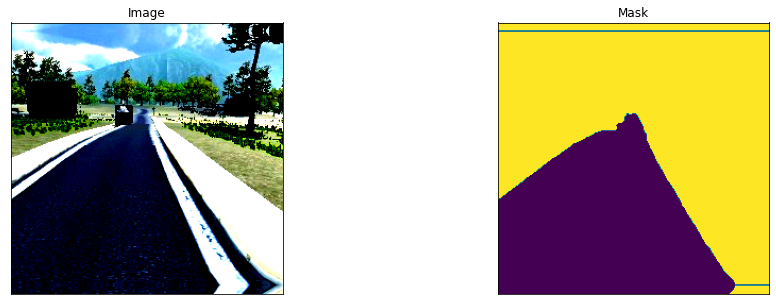

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 256, 256) (1, 256, 256) ./data/images/168.jpg ./data/masks/168_color_mask.png


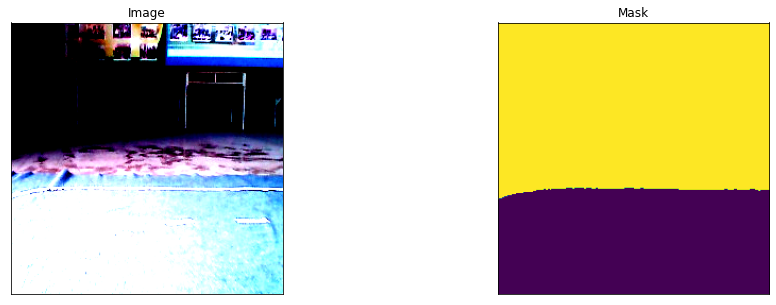

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 256, 256) (1, 256, 256) ./data/images/1017.jpg ./data/masks/1017_color_mask.png


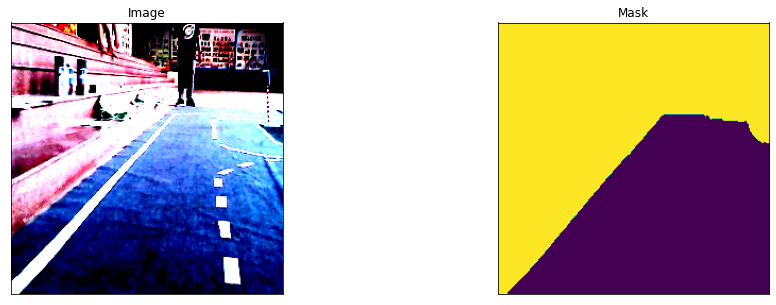

In [53]:
for i in range(4):
    image, mask = train_data[i]
    print(image.shape,mask.shape,train_data.list_img[i],train_data.get_file_mask(i))
    visualize(image=image, mask=mask)

In [54]:
train_loader =torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True, num_workers=12)
valid_loader = torch.utils.data.DataLoader(vali_data, batch_size=1, shuffle=False, num_workers=4)

In [55]:
len(train_loader),len(vali_data)

(206, 50)

In [18]:
model  = torch.load("./best.pt")
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])


In [19]:
train_epoch = TrainEpoch(
    model, 
    loss=loss, 
    metrics=me, 
    optimizer=optimizer,
    device="cuda",
    verbose=True,
)

In [61]:
for i in range(10):
    train_epoch.run(train_loader)
    val_epoch.run(valid_loader)

valid: 100%|██████████| 50/50 [00:01<00:00, 31.86it/s, dice_loss - 0.02624, iou_score - 0.9501, accuracy - 0.9677]


In [45]:
val_epoch = ValidEpoch(
    model,
    loss=loss,
    metrics=me,
    device="cuda",
    verbose=True
)

In [46]:
val_epoch.run(valid_loader)

valid: 100%|██████████| 50/50 [00:01<00:00, 30.36it/s, dice_loss - 0.05585, iou_score - 0.9362, accuracy - 0.9582]


{'dice_loss': 0.05584565877914429,
 'iou_score': 0.9362153387069702,
 'accuracy': 0.9581625366210937}

In [59]:
torch.save(model,"best.pt")

In [32]:
z=vali_data.list_img[0]

In [36]:
vali_data.get_file_mask(0)

'./validation/masks/3919_color_mask.png'

In [35]:
name = vali_data.list_img[0].split(os.path.sep)[-1].split(".")[0]

'3919'